$\text{Economics 502-B} \\ \text{Dheer Avashia} \\ \text{Problem Set 2}$

In [146]:
#Install packages
import numpy as np
from quantecon.distributions import BetaBinomial
import matplotlib.pyplot as plt
from scipy.optimize import fsolve as fs
from scipy.optimize import minimize as mini
from numba import njit
from collections import namedtuple
from quantecon import compute_fixed_point
from quantecon.markov import tauchen

$\text{Question 1}$

$\text{a)}$ The following Bellman Equation may be used for the case in which there is only a
probability $\gamma$ with $0 < \gamma < 1$ that the worker receives an offer in each period:
$$\begin{align} v^*(w) = max \left\{\frac{w}{1-\beta},c + \beta \left[\gamma \sum_{w' \in W}v^*(w)\varphi(w)+ (1-\gamma)c\right]\right\}\end{align}$$ 



$\text{b)}$ Suppose $h^* := c + \beta \left[\gamma \sum_{w' \in W}v^*(w)\varphi(w)+ (1-\gamma)c\right]$ then note that the reservation wage must be where $h^*=\frac{w}{1-\beta}$. Note that as $\gamma$ increases the effect of the uncertainity of getting an offer in the next period decreases. This means that a worker will demand a higher reservation wage, as compared to when the uncertainity of getting an offer is higher. Mathematically, this equation when written out in terms of $w$, is increasring in $\gamma$.

$\text{c)}$ Solve the model computationally for a generic $\gamma$

In [147]:
# NamedTuple Model
ModelJobSearch = namedtuple("Model", ("n", "w_vals", "φ", "β", "c","γ"))

def create_job_search_model(
        n=50,        # wage grid size
        w_min=10.0,  # lowest wage
        w_max=60.0,  # highest wage
        a=200,       # wage distribution parameter
        b=100,       # wage distribution parameter
        β=0.96,      # discount factor
        c=10.0,      # unemployment compensation
        γ=0.45,      #Probablity of offer
    ):
    """
    Creates the parameters for job search model and returns the
    instance of namedtuple Model
    """
    w_vals = np.linspace(w_min, w_max, n+1)
    φ = BetaBinomial(n, a, b).pdf()
    return ModelJobSearch(n=n, w_vals=w_vals, φ=φ, β=β, c=c, γ=γ)

In [148]:
#Bellman Operator
@njit
def T(v, model):
    """ The Bellman operator. """
    n, w_vals, φ, β, c, γ= model
    cont_val= c + β*(γ*(np.dot(v , φ))+(1-γ)*c)
    stop_val=(w_vals)/(1-β)
    return np.maximum(stop_val,cont_val)

In [149]:
default_model = create_job_search_model()

In [150]:
@njit
def get_greedy(v, model):
    """ Get a v-greedy policy. """
    n, w_vals, φ, β, c, γ= model
    σ = w_vals / (1 - β) >= c + β*(γ*(np.dot(v,φ))+(1-γ)*c)  # Boolean policy vector
    return σ

In [151]:
def vfi(model=default_model):
    """ Solve the infinite-horizon IID job search model by VFI. """
    v_init = np.zeros_like(model.w_vals)
    v_star = compute_fixed_point(lambda v: T(v, model), v_init,
                             error_tol=1e-3, max_iter=1000, print_skip=25)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star

In [152]:
vfi()

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
3            3.968e-10      1.604e-01         
Converged in 3 steps


(array([ 483.28,  483.28,  483.28,  483.28,  483.28,  483.28,  483.28,
         483.28,  483.28,  483.28,  500.  ,  525.  ,  550.  ,  575.  ,
         600.  ,  625.  ,  650.  ,  675.  ,  700.  ,  725.  ,  750.  ,
         775.  ,  800.  ,  825.  ,  850.  ,  875.  ,  900.  ,  925.  ,
         950.  ,  975.  , 1000.  , 1025.  , 1050.  , 1075.  , 1100.  ,
        1125.  , 1150.  , 1175.  , 1200.  , 1225.  , 1250.  , 1275.  ,
        1300.  , 1325.  , 1350.  , 1375.  , 1400.  , 1425.  , 1450.  ,
        1475.  , 1500.  ]),
 array([False, False, False, False, False, False, False, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]))

$\text{d)}$ Plot how the reservation wage varies with $\gamma$ for $\gamma = 0.1, 0.2, .....0.9, 1$

In [153]:
res_wages= np.zeros(10)
for gamma_i in range(1,11):
    γ = gamma_i/10
    model = create_job_search_model(γ=γ)
    greedy_policy= list(vfi(model=model)[1])
    res_wage = model.w_vals[0] + greedy_policy.index(True)
    res_wages[gamma_i-1]= res_wage

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
2            0.000e+00      1.848e-04         
Converged in 2 steps
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
2            0.000e+00      1.194e-04         
Converged in 2 steps
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
3            0.000e+00      1.731e-04         
Converged in 3 steps
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
3            4.889e-12      1.552e-04         
Converged in 3 steps
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
3            1.891e-08      1.171e-04         
Converged in 3 steps
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
3            1.244e-05      1.154e-04         
Converged in 3 steps
Iteration    Distance       Elapsed (sec

[10. 10. 14. 18. 22. 26. 30. 34. 38. 44.]


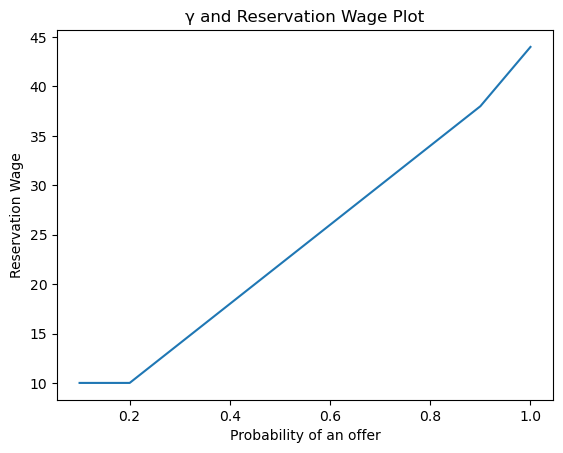

In [154]:
print(res_wages)
γ_vals=np.arange(0.1,1.1,0.1)
plt.plot(γ_vals,res_wages)
plt.xlabel('Probability of an offer')
plt.ylabel('Reservation Wage')
plt.title('γ and Reservation Wage Plot')
plt.show()

$\text{Question 2}$

$\text{a)}$ Observe that our Markov stochastic matrix is of the form $M=\begin{pmatrix} 0.6 & 0.4 \\ 0.2 & 0.8 \end{pmatrix}$. Note that this is aperiodic and irreducible, therefore a steady state must exsist. Consider the following:

In [155]:
M = np.array([[0.6,0.4],[0.2,0.8]]) 
# N iterations of M^N
N= 1000 
for i in range(1,N+1):
    Steady_state= np.linalg.matrix_power(M,i)
    if i in [1,10,50,100,250,500,1000]:
        print(Steady_state, '\n')

[[0.6 0.4]
 [0.2 0.8]] 

[[0.33340324 0.66659676]
 [0.33329838 0.66670162]] 

[[0.33333333 0.66666667]
 [0.33333333 0.66666667]] 

[[0.33333333 0.66666667]
 [0.33333333 0.66666667]] 

[[0.33333333 0.66666667]
 [0.33333333 0.66666667]] 

[[0.33333333 0.66666667]
 [0.33333333 0.66666667]] 

[[0.33333333 0.66666667]
 [0.33333333 0.66666667]] 



Observe that the iterations converge to steady state stochastic vector $\psi=(\frac{1}{3},\frac{2}{3})$. Then the Bellman equation is charectrized as follows: $$\begin{align*} v^*(w,e_t) &= \max\left\{ \sum_{k=t}^{\infty} \beta^{k-t} \left( \psi_0w + \psi_1\frac{3}{2}w \right), c + \beta \sum_{w' \in W} \psi_0 v^*\left(w',0\right)P\left(w,w'\right) + \psi_1 v^*\left(w',1\right)P\left(w,w')\right)\right\} \\ &= \max\left\{ \sum_{k=t}^{\infty} \beta^{k-t} \left( \frac{1}{3}w + \frac{2}{3}\cdot\frac{3}{2}w \right), c + \beta \sum_{w' \in W} \frac{1}{3} v^*\left(w',0\right)P\left(w,w'\right) + \frac{2}{3} v^*\left(w',1\right)P\left(w,w')\right)\right\} \\ &= \max\left\{ \frac{1}{1-\beta} \cdot \left( \frac{4}{3}w \right), c + \beta \sum_{w' \in W} \frac{1}{3} v^*\left(w',0\right)P\left(w,w'\right) + \frac{2}{3} v^*\left(w',1\right)P\left(w,w')\right)\right\} \\ &= \max\left\{ \frac{4w}{3\cdot(1-\beta)}, c + \beta \sum_{w' \in W} v^*\left(w',e_{t}\right)P\left(w,w'\right)\right\} \end{align*} \\ $$

$\text{b)}$ I believe it is the same because despite out starting state we always converge to the steady state $\psi$ which follows from the argument above.

$\text{c)}$

In [14]:
# NamedTuple Model
Model = namedtuple("Model", ("n", "w_vals", "P", "β", "c"))

def create_markov_js_model(
        n=200,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.98,      # discount factor
        c=1.0        # unemployment compensation
    ):
    """
    Creates an instance of the job search model with Markov wages.
    """
    mc = tauchen(n, ρ, ν)
    w_vals, P = np.exp(mc.state_values), mc.P
    return Model(n=n, w_vals=w_vals, P=P, β=β, c=c)

In [15]:
model_2= create_markov_js_model()

In [16]:
@njit
def T_1(v, model):
    n, w_vals, P, β, c = model
    h = c + β * np.dot(P, v)
    e = (4*(w_vals)) / (3*(1 - β))
    return np.maximum(e, h)

In [17]:
@njit
def get_greedy_mark(v, model):
    """ Get a v-greedy policy. """
    n, w_vals, P, β, c = model
    σ =(4*(w_vals)) / (3*(1 - β)) >= c + β * np.dot(P, v)  # Boolean policy vector
    return σ

In [18]:
def vfi_mark(model):
    """ Solve the infinite-horizon Markov IID job search model by VFI. """
    v_init = np.zeros_like(model.w_vals)
    v_star = compute_fixed_point(lambda v: T_1(v, model), v_init,
                             error_tol=1e-5, max_iter=1000, print_skip=25)
    σ_star = get_greedy_mark(v_star, model)
    return v_star, σ_star

In [19]:
soln=vfi_mark(model_2)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           8.307e-01      4.503e-01         
50           2.185e-01      4.515e-01         
75           6.855e-02      4.526e-01         
100          2.253e-02      4.537e-01         
125          7.501e-03      4.549e-01         
150          2.499e-03      4.560e-01         
175          8.323e-04      4.571e-01         
200          2.773e-04      4.582e-01         
225          9.236e-05      4.594e-01         
250          3.077e-05      4.608e-01         
275          1.025e-05      4.618e-01         
276          9.808e-06      4.619e-01         
Converged in 276 steps


In [20]:
reswage_value= soln[0][list(soln[1]).index(True)]
print('The value function corresponding to the wage state is',reswage_value,'.This means for all wage states that yield an value function of',reswage_value,'or greater, one should accept.')

The value function corresponding to the wage state is 115.14044047352192 .This means for all wage states that yield an value function of 115.14044047352192 or greater, one should accept.


In [21]:
reswage = model_2.w_vals[list(soln[1]).index(True)]
print('This corresponds to the wage value of',reswage,'.One must still recover the exact wage by backing out the state value from the formulation of w_vals')

This corresponds to the wage value of 1.7271066071028303 .One must still recover the exact wage by backing out the state value from the formulation of w_vals


$\text{Question 3}$

$\text{a)}$ Consider the following Bellman Equation that is defined peice-wise to modify the model by letting the unemployment
compensation $c$ be reduced to a subsistence level $\frac{c}{2}$ after $T_c=24$ periods of unemployment: $$ \begin{align*}
\left(Tv^{*}_{u}\right)\left(w\right)=\max\left\{ \frac{1}{1-\beta\left(1-\alpha\right)}\left(w+\alpha\beta\left(Pv_{u}^{*}\right)\left(w\right)\right),\begin{cases} c+\beta\left(Pv_{u}^{*}\right)\left(w\right) & \text{for $T_c \leq 24$} \\ \frac{c}{2}+\beta\left(Pv_{u}^{*}\right)\left(w\right) & \text{for $T_c > 24$}
\end{cases}
\right\} 
\end{align*}$$

$\text{b)}$ Given that our function is defined piece-wise for a range of periods, the reservation wage calculated by the value of the wage where the left hand term of the max problem is equal to the right hand. It is easy to see that the reservation wage varies over a spell of unemployment given the peice-wise charectrization. 

$\text{c)}$

In [61]:
# NamedTuple Model
Model = namedtuple("Model", ("n", "w_vals", "P", "β", "c", "α"))


def create_js_with_sep_model(
        n=200,          # wage grid size
        ρ=0.9, ν=0.2,   # wage persistence and volatility
        β=0.98, α=0.1,  # discount factor and separation rate
        c=1.0):         # unemployment compensation
    """Creates an instance of the job search model with separation."""
    mc = tauchen(n, ρ, ν)
    w_vals, P = np.exp(mc.state_values), mc.P
    return Model(n=n, w_vals=w_vals, P=P, β=β, c=c, α=α)

In [84]:
@njit
# First peice-wise charectrization of operator 
def T_2(v, model): 
    """The Bellman operator for the value of being unemployed."""
    n, w_vals, P, β, c, α = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * np.dot(P, v))
    reject = c + β * np.dot(P, v)
    return np.maximum(accept, reject)

In [85]:
@njit
#Second piece-wise charectrization of operator 
def T_3(v, model):
    """The Bellman operator for the value of being unemployed."""
    n, w_vals, P, β, c, α = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * np.dot(P, v))
    reject = c/2 + β * np.dot(P, v)
    return np.maximum(accept, reject)

In [86]:
@njit
# First peice-wise charectrization of policy 
def get_greedy_sep(v, model):
    """ Get a v-greedy policy."""
    n, w_vals, P, β, c, α = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * np.dot(P, v))
    reject = c + β * np.dot(P, v)
    σ = accept >= reject
    return σ

In [87]:
@njit
# Second peice-wise charectrization of policy 
def get_greedy_sep_3(v, model):
    """ Get a v-greedy policy."""
    n, w_vals, P, β, c, α = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * np.dot(P, v))
    reject = c/2 + β * np.dot(P, v)
    σ = accept >= reject
    return σ

In [163]:
def vfi_sep(model):
    """Solve by VFI."""
    v_init = np.zeros(model.w_vals.shape)
    v_star = compute_fixed_point(lambda v: T_2(v, model), v_init, error_tol=1e-5, max_iter=1000, print_skip=25)
    σ_star = get_greedy_sep(v_star, model)
    return v_star, σ_star

In [166]:
def vfi_sep_new(model):
    """Solve by VFI."""
    v_init = np.zeros(model.w_vals.shape)
    v_star = compute_fixed_point(lambda v: T_3(v, model), v_init, error_tol=1e-5, max_iter=1000, print_skip=25)
    σ_star = get_greedy_sep_3(v_star, model)
    return v_star, σ_star

In [156]:
# Create a function that uses an instance as an arguement and checks whether we have acceptance in first 24 periods if yes use the first charectrization if not use the second to solve for optimal v and sigma star.  
def Substinence(model): 
    result = vfi_sep(model)
    if result[1][24]== True:  
        return result[0], result[1]  
    else:
        return vfi_sep_new(model_3)

In [158]:
model_3=create_js_with_sep_model() # Create instance 
Substinence(model_3) #Use as argument

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           1.077e+00      3.699e-03         
50           3.114e-01      6.844e-03         
75           1.093e-01      1.116e-02         
100          4.149e-02      1.564e-02         
125          1.621e-02      1.886e-02         
150          6.367e-03      2.214e-02         
175          2.502e-03      2.522e-02         
200          9.894e-04      2.825e-02         
225          3.953e-04      3.167e-02         
250          1.580e-04      3.642e-02         
275          6.318e-05      4.089e-02         
300          2.526e-05      4.489e-02         
325          1.010e-05      4.893e-02         
326          9.736e-06      4.911e-02         
Converged in 326 steps
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           8.403e-01      3.994e-03         
50           1.893e-01      8.334e-03         
75           5.012e-02      1.210e-02    

(array([ 51.42216602,  51.45542109,  51.48982826,  51.52537541,
         51.56204913,  51.59983495,  51.6387176 ,  51.67868124,
         51.71970968,  51.76178666,  51.80489599,  51.8490218 ,
         51.89414874,  51.94026207,  51.9873479 ,  52.03539328,
         52.08438628,  52.13431618,  52.18517345,  52.23694988,
         52.2896386 ,  52.34323412,  52.39773234,  52.45313061,
         52.50942765,  52.56662361,  52.62472002,  52.6837198 ,
         52.74362718,  52.80444776,  52.8661884 ,  52.92885724,
         52.99246363,  53.05701815,  53.12253256,  53.18901975,
         53.25649377,  53.32496977,  53.394464  ,  53.46499379,
         53.53657755,  53.60923476,  53.68298596,  53.75785278,
         53.83385789,  53.91102508,  53.9893792 ,  54.06894623,
         54.14975327,  54.23182858,  54.31520158,  54.39990291,
         54.48596444,  54.57341929,  54.66230193,  54.75264815,
         54.84449514,  54.93788154,  55.03284749,  55.12943469,
         55.22768644,  55.32764773,  55.

$\text{d)}$

In [172]:
default_model = create_js_with_sep_model()


def plot_main(model=default_model,
              savefig=False,
              figname="./figures/markov_js_with_sep_1.pdf"):
    n, w_vals, P, β, c, α = model
    v_star, σ_star = Substinence(model)

    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * np.dot(P, v_star))
    h_star = c + β * np.dot(P, v_star)

    w_star = np.inf
    for (i, w) in enumerate(w_vals):
        if accept[i] >= h_star[i]:
            w_star = w
            break

    assert w_star != np.inf, "Agent never accepts"

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_vals, h_star, linewidth=4, ls="--", alpha=0.4,
            label="continuation value")
    ax.plot(w_vals, accept, linewidth=4, ls="--", alpha=0.4,
            label="stopping value")
    ax.plot(w_vals, v_star, "k-", alpha=0.7, label=r"$v_u^*(w)$")
    ax.legend(frameon=False)
    ax.set_xlabel(r"$w$")
    if savefig:
        fig.savefig(figname)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           1.077e+00      3.772e-03         
50           3.114e-01      7.356e-03         
75           1.093e-01      1.065e-02         
100          4.149e-02      1.375e-02         
125          1.621e-02      1.858e-02         
150          6.367e-03      2.264e-02         
175          2.502e-03      2.671e-02         
200          9.894e-04      3.080e-02         
225          3.953e-04      3.472e-02         
250          1.580e-04      3.853e-02         
275          6.318e-05      4.257e-02         
300          2.526e-05      4.679e-02         
325          1.010e-05      5.069e-02         
326          9.736e-06      5.086e-02         
Converged in 326 steps
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           8.403e-01      4.459e-03         
50           1.893e-01      8.273e-03         
75           5.012e-02      1.222e-02    

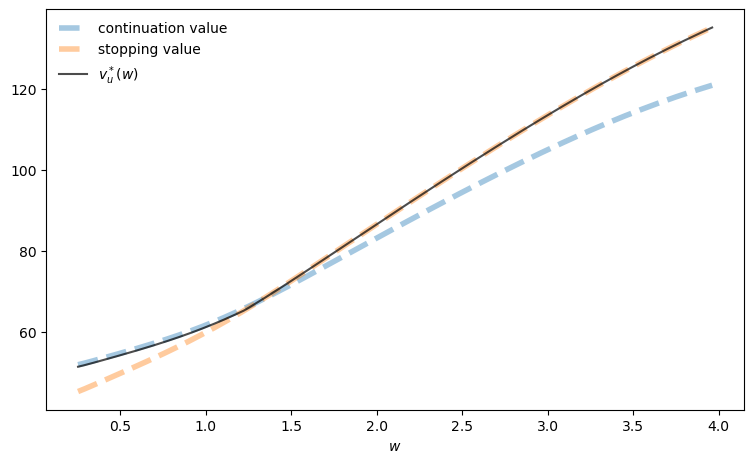

In [173]:
plot_main()